In [8]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [9]:
import pickle as pk
import numpy as np
import pandas as pd
from copy import deepcopy

# from phys.plot_scripts import generic_plot_utils as rr_gpu
# from phys.phys_utils import nnan_pearsonr as nnan_pearsonr
# from phys import data_utils, phys_utils
# from phys.decode_utils import Decoder_3Ddata
from utils import generic_plot_utils as rr_gpu
from utils.phys_utils import nnan_pearsonr as nnan_pearsonr
from utils import data_utils, phys_utils
from utils.decode_utils import Decoder_3Ddata

current_palette = sns.color_palette()

In [10]:
cmap = plt.get_cmap('Dark2', 8)
# figoutpath_base = '/om/user/rishir/figs/mpong_phys/paper_scratch_202202/'


In [11]:
condition = 'occ'
subject_id = 'all_hand_dmfc'
timebinsize = 50
neural_data_to_use = 'neural_responses_reliable_FactorAnalysis_50'
masks_to_test_suffix = 'start_end_pad0'

# figoutpath = '%s/%s%d/%s/decode_%s%s/' % (figoutpath_base, subject_id, timebinsize,
#                                           neural_data_to_use, masks_to_test_suffix, condition)


data_aug = data_utils.load_neural_dataset(subject_id=subject_id,
                                                   timebinsize=timebinsize,
                                                   recompute_augment=False)

mask_fn_neur = mask_fn_beh =  masks_to_test_suffix
data_neur_nxcxt = np.array(data_aug['neural_responses_reliable_FactorAnalysis_50'][condition])
# data_neur_nxcxt = np.array(data_aug['neural_responses_reliable'][condition])
beh_to_decode = ['ball_pos_x_TRUE', 'ball_pos_y_TRUE']
data_beh_bxcxt = np.array([data_aug['behavioral_responses'][condition][fk] for fk in beh_to_decode])
mask_neur_cxt = np.array(data_aug['masks'][condition][mask_fn_neur])
mask_beh_cxt = np.array(data_aug['masks'][condition][mask_fn_beh])



In [12]:
def get_position_error_metric(xy_t_ixb, xy_p_ixb, suffix=''):
    niter = xy_t_ixb.shape[0]
    err_met = {}
    err = np.nanmean(np.sum((xy_t_ixb - xy_p_ixb)**2, axis=2)**0.5, axis=1)
    err_met['rmse_mu%s'%suffix] = np.nanmean(err)
    err_met['rmse_sig%s'%suffix] = np.nanstd(err)
    
    err = np.nanmean(np.mean(np.abs(xy_t_ixb - xy_p_ixb), axis=2), axis=1)
    err_met['mae_mu%s'%suffix] = np.nanmean(err)
    err_met['mae_sig%s'%suffix] = np.nanstd(err)
    
    err = np.nanmean(np.abs(xy_t_ixb[:,:,0] - xy_p_ixb[:,:,0]), axis=1)
    err_met['maex_mu%s'%suffix] = np.nanmean(err)
    err_met['maex_sig%s'%suffix] = np.nanstd(err)
    
    err = np.nanmean(np.abs(xy_t_ixb[:,:,1] - xy_p_ixb[:,:,1]), axis=1)
    err_met['maey_mu%s'%suffix] = np.nanmean(err)
    err_met['maey_sig%s'%suffix] = np.nanstd(err)
    
    err = np.array([nnan_pearsonr(xy_t_ixb[i,:,0],xy_p_ixb[i,:,0])[0] for i in range(niter)])
    err_met['rx_mu%s'%suffix] = np.nanmean(err)
    err_met['rx_sig%s'%suffix] = np.nanstd(err)
    
    err = np.array([nnan_pearsonr(xy_t_ixb[i,:,1],xy_p_ixb[i,:,1])[0] for i in range(niter)])
    err_met['ry_mu%s'%suffix] = np.nanmean(err)
    err_met['ry_sig%s'%suffix] = np.nanstd(err)
    
    return err_met

def make_new_group(data, train_size, regroup_mode=None):
    if regroup_mode is None:
        metavar = np.array(data_aug['meta']['n_bounce_correct'])
        train_0 = train_1 = metavar.shape[0]  * train_size
        g = data['g']
    else:
        metavar = np.array(data_aug['meta'][regroup_mode])
        thres = np.nanmedian(metavar)
        metavar_1 = np.nonzero(metavar > thres)[0]
        metavar_0 = np.nonzero(metavar <= thres)[0]
        train_size = 0.5
        train_0 = len(metavar_1)
        train_1 = len(metavar_0)
        g = np.expand_dims([float(g[0] in metavar_1) for g in data['g']], axis=1)
    return g, train_size, train_0, train_1

        

def run_one(data_neur_nxcxt,data_beh_bxcxt, mask_neur_cxt, mask_beh_cxt, train_size=0.5, 
            regroup_mode=None, shuffle_features=False, nfeatures_sample=None):
        
    decoder_specs = {
            'train_size': train_size,
            'niter': 10,
            'nfeatures_sample': nfeatures_sample,
            'groupby': 'condition',
            'matched_timepoints': True,
            'groupshufflesplit': True,
        }
    dec = Decoder_3Ddata(**decoder_specs)
    
    x_nxcxtm = dec.mask_3ddata(data_neur_nxcxt, mask_neur_cxt)
    y_bxcxtm = dec.mask_3ddata(data_beh_bxcxt, mask_beh_cxt)
    data = dec.get_data(x_nxcxtm, y_bxcxtm, x2_nxcxt=None)
    g, train_size, train_0, train_1 = make_new_group(data, train_size, regroup_mode=regroup_mode)
    dec.train_size = train_size
    data['g'] = g
    
    if shuffle_features:
        x = np.array(data['x'])
        data['x'] = np.random.random(x.shape)
    
    res = dec.decode_base(data)
    metrics = {}
    metrics.update(res)
    metrics['train_0'] = train_0
    metrics['train_1'] = train_1

    tmp = get_position_error_metric(res['y_true_dist'], res['y_pred_dist'], suffix='')
    metrics.update(tmp)
    
    if regroup_mode is not None:
        idx_1 = np.nonzero(data['g'] == 1)[0]
        idx_0 = np.nonzero(data['g'] == 0)[0]
        
        for j, idx_curr in enumerate([idx_0, idx_1]):
            yt, yp = res['y_true_dist'][:,idx_curr,:], res['y_pred_dist'][:,idx_curr,:]
            tmp = get_position_error_metric(yt, yp, suffix='_%d'%j)
            metrics.update(tmp)
            
    return metrics

In [13]:
met_all, met_shuf_all = [], []
for train_size in np.arange(0.02,0.8,0.1):
    met = run_one(data_neur_nxcxt,data_beh_bxcxt, mask_neur_cxt, mask_beh_cxt, train_size,
                  regroup_mode=None)
    met_all.append(met)
    
    met = run_one(data_neur_nxcxt,data_beh_bxcxt, mask_neur_cxt, mask_beh_cxt, train_size,
                  regroup_mode=None, shuffle_features=True)
    met_shuf_all.append(met)


met_regrouped = {}
for fk in ['n_bounce_correct', 'yf', 'dx', 'dy', 'x0', 'y0']:
    met_regrouped[fk] = run_one(data_neur_nxcxt,data_beh_bxcxt, mask_neur_cxt, mask_beh_cxt, 
                     0.5, regroup_mode=fk)



[1.58, 9.48, 17.38, 25.280000000000005, 33.18, 41.08, 48.98000000000001, 56.88000000000001]
[0.700616055393605, 0.92721921162779, 0.9504653995701029, 0.9597678796738827, 0.9648916220523038, 0.9668301690931085, 0.9686516938922969, 0.9700189025493478]
[0.11876813379336118, 0.013559679804566484, 0.007983616815375766, 0.00296198961500982, 0.0020938333350638168, 0.003973979462996279, 0.005451764549936355, 0.004861612496546012]
n_bounce_correct
[27, 52]
[0.9536088020347568, 0.9652669352788847]
[1.58, 9.48, 17.38, 25.280000000000005, 33.18, 41.08, 48.98000000000001, 56.88000000000001]
[0.11590392773927063, 0.5285201881067192, 0.6745613800467359, 0.7510166693187228, 0.7885504309252898, 0.823863606340393, 0.8299924973897472, 0.833982822600832]
[0.0745301546916956, 0.0784437510888463, 0.027812705224201477, 0.033616404544404906, 0.049245098845581405, 0.03457944530246521, 0.028884037322814686, 0.024432474469344982]
n_bounce_correct
[27, 52]
[0.7116492183140468, 0.8635581455733224]


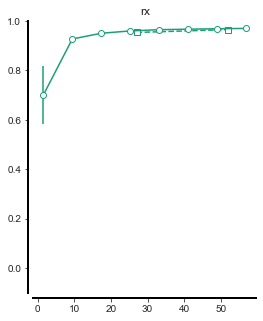

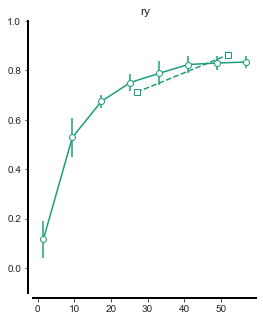

In [14]:
plot_regroup_keys = ['n_bounce_correct']
cols = [cmap(0), [0.5, 0.5, 0.5]]
for metricn in ['rx', 'ry']:

    f,axes = plt.subplots(1,1,figsize=(4,5))
    for mi, met_curr in enumerate([met_all]): # met_shuf_all
        x = [met['train_1'] for met in met_curr]
        mu = [met['%s_mu'%metricn] for met in met_curr]
        sig = [met['%s_sig'%metricn] for met in met_curr]
        axes.errorbar(x, mu, yerr=sig, fmt='-o', mfc='w', color=cols[mi])
        print(x)
        print(mu)
        print(sig)

    for met_fk in plot_regroup_keys:
        met_other = met_regrouped[met_fk]

        X = [met_other['train_0'], met_other['train_1']]
        Y = [met_other['%s_mu_0'%metricn], met_other['%s_mu_1'%metricn]]
        axes.plot(X, Y,'--s', label=met_fk, mfc='w', color=cols[0])
        print(met_fk)
        print(X)
        print(Y)
#     axes.legend()
    axes.set_ylim([-0.1,1])
    axes.set_title(metricn)
    rr_gpu.make_axis_nice(axes)
    # figoutfn = '%s/ntraining_samples_%s.pdf' % (figoutpath, metricn)
    # f.savefig(figoutfn)
    # print('saved to %s' % figoutfn)